# **Feature Engineering Notebook**

## Objectives

*  Evaluate which transformations are beneficial for our dataset

## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* Generate a list of engineering approaches for each variable


---

In [1]:
# Ignore FutureWarnings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
file_path = "outputs/datasets/cleaned"

TrainSet = pd.read_csv(f"{file_path}/TrainSet.csv")
TrainSet.head(3)
TrainSet.dtypes

Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

Test Set

In [5]:
TestSet = pd.read_csv(f"{file_path}/TestSet.csv")
TestSet.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   62   63857      195239          414               5               3   
1   40  149331      182099          678              82               2   
2   53   76685       18866          597              19               1   

   InterestRate  LoanTerm  DTIRatio   Education EmploymentType MaritalStatus  \
0         17.19        60      0.53  Bachelor's      Full-time      Divorced   
1         12.60        24      0.43    Master's      Part-time       Married   
2         18.69        60      0.28  Bachelor's      Full-time        Single   

  HasMortgage HasDependents LoanPurpose HasCoSigner  Default  
0         Yes           Yes        Home          No        0  
1         Yes            No        Home          No        0  
2          No           Yes   Education          No        1

# Data Exploration

To identify potential transformations, we first revisit the Profile Report generated earlier.
This allows us to assess:

* The distributions of numerical variables (to detect skewness or outliers)
* The cardinality and balance of categorical variables
* Possible data scaling needs due to large differences in magnitude

Based on these insights, we will determine which variables may benefit from transformations such as scaling, normalization or encoding before modeling.

In [6]:
from ydata_profiling import ProfileReport
    
# Convert object columns to categorical so that it can be displayed properly in the report
TrainSet_cat = TrainSet.copy()
for col in TrainSet_cat.select_dtypes(include='object').columns:
    TrainSet_cat[col] = TrainSet_cat[col].astype('category')
    
pandas_report = ProfileReport(df=TrainSet_cat, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The ProfileReport suggests different transformations depending on the variable type and distribution.

Categorical variables should be handled differently based on whether they are nominal or ordinal. The numerical variables are mostly uniformally distributed, so numerical transformations may help improve model performance. Additionally, numerical variables should be scaled to ensure comparable ranges, which benefits many machine learning algorithms. There are no outliers that have to be treated in this dataset. Finally, correlated features should be identified for possible removal to reduce redundancy.

Transformation Steps:
1. Categorical variables
    * Nominal Variables: OneHotEncoder
        * `EmploymentType`, `MaritalStatus`, `LoanPurpose`, `HasMortgage`, `HasDependents`, `HasCoSigner`
    * Ordinal Variables: OrdinalEncoder
        * `Education`
2. Numerical Variables
    * `NumCreditLines` and `LoanTerm`: No transformation as they have to be treated as ordinal categorical variables
    * All other numerical variables: Numerical transformation, since they do not have a normal distribution 
3. All Variables: Smart correlated selection, so any correlated features will be removed
4. Scaling variables

---

# Feature Engineering

In [7]:
import scipy.stats as stats
# for vs code
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

## Categorical Variables

### Nominal Variables: OneHotEncoder

* Step 1: Select variables and create a separate DataFrame

In [8]:
variables_engineering= ["EmploymentType", "MaritalStatus", "LoanPurpose", "HasMortgage", "HasDependents", "HasCoSigner"]
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

EmploymentType MaritalStatus LoanPurpose HasMortgage HasDependents  \
0      Part-time      Divorced   Education          No            No   
1  Self-employed      Divorced        Auto         Yes           Yes   
2  Self-employed      Divorced        Home          No            No   

  HasCoSigner  
0         Yes  
1         Yes  
2         Yes

* Step 2: Create engineered variables by applying the encoder

In [9]:
encoder = OneHotEncoder(variables=variables_engineering)
df_feat_eng = encoder.fit_transform(df_engineering)
df_feat_eng.head(3)

EmploymentType_Part-time  EmploymentType_Self-employed  \
0                         1                             0   
1                         0                             1   
2                         0                             1   

   EmploymentType_Full-time  EmploymentType_Unemployed  \
0                         0                          0   
1                         0                          0   
2                         0                          0   

   MaritalStatus_Divorced  MaritalStatus_Single  MaritalStatus_Married  \
0                       1                     0                      0   
1                       1                     0                      0   
2                       1                     0                      0   

   LoanPurpose_Education  LoanPurpose_Auto  LoanPurpose_Home  \
0                      1                 0                 0   
1                      0                 1                 0   
2                      0                 0                 1   

   LoanPurpose_Business  LoanPurpose_Other  HasMortgage_No  HasMortgage_Yes  \
0                     0                  0               1                0   
1                     0                  0               0                1   
2                     0                  0               1                0   

   HasDependents_No  HasDependents_Yes  HasCoSigner_Yes  HasCoSigner_No  
0                 1                  0                1               0  
1                 0                  1                1               0  
2                 1                  0                1               0

* Step 3: Assess transformation by comparing engineered variables distribution to original ones

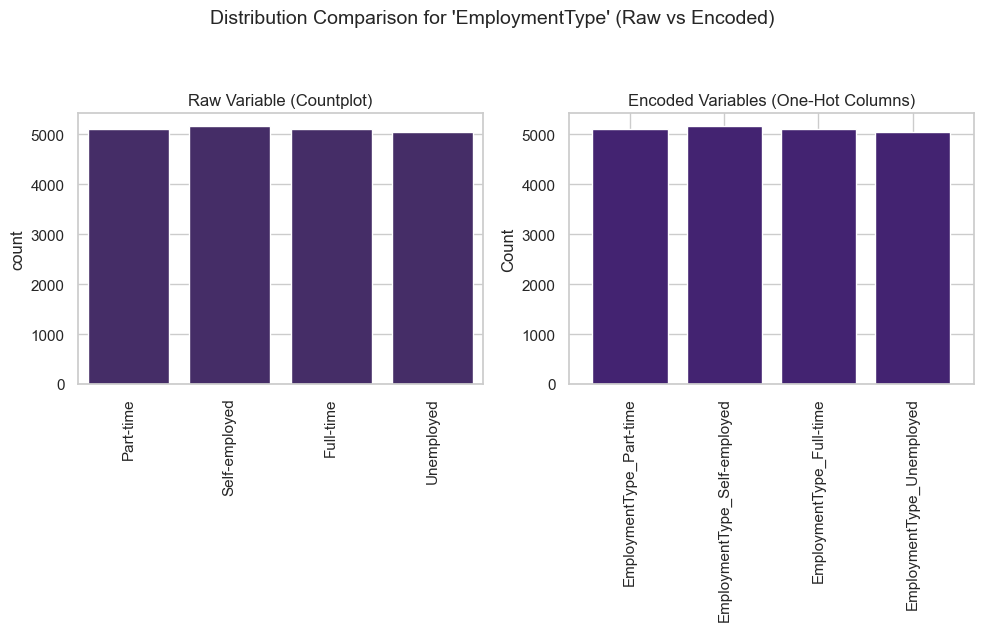

Count Table (Raw Variable):


EmploymentType  Count
0  Self-employed   5163
1      Full-time   5107
2      Part-time   5099
3     Unemployed   5058


Count Table (Encoded Variables):


Encoded Column  Count
0      EmploymentType_Part-time   5099
1  EmploymentType_Self-employed   5163
2      EmploymentType_Full-time   5107
3     EmploymentType_Unemployed   5058

---


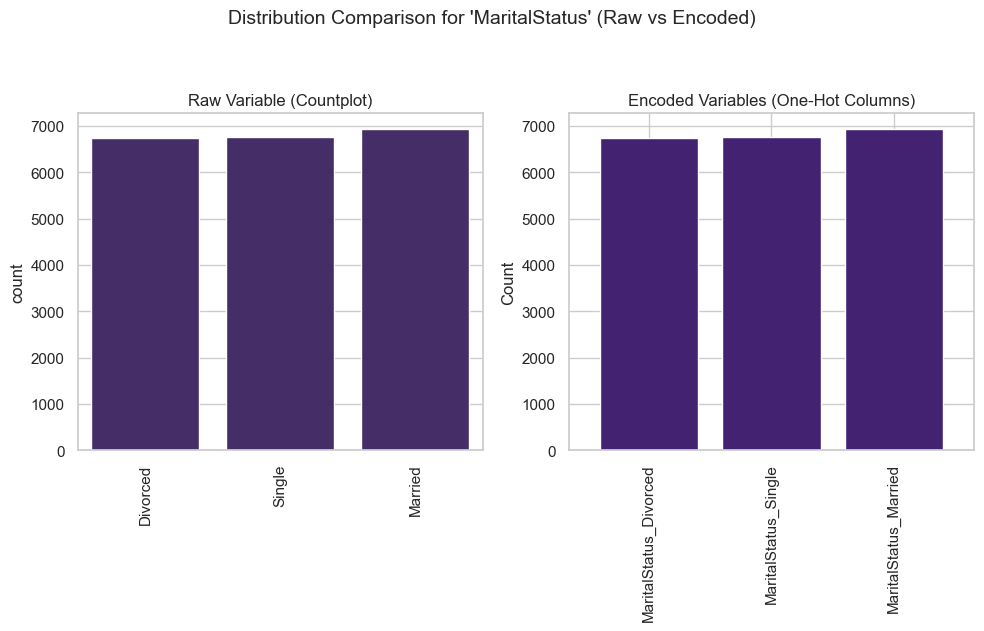

Count Table (Raw Variable):


MaritalStatus  Count
0       Married   6922
1        Single   6764
2      Divorced   6741


Count Table (Encoded Variables):


Encoded Column  Count
0  MaritalStatus_Divorced   6741
1    MaritalStatus_Single   6764
2   MaritalStatus_Married   6922

---


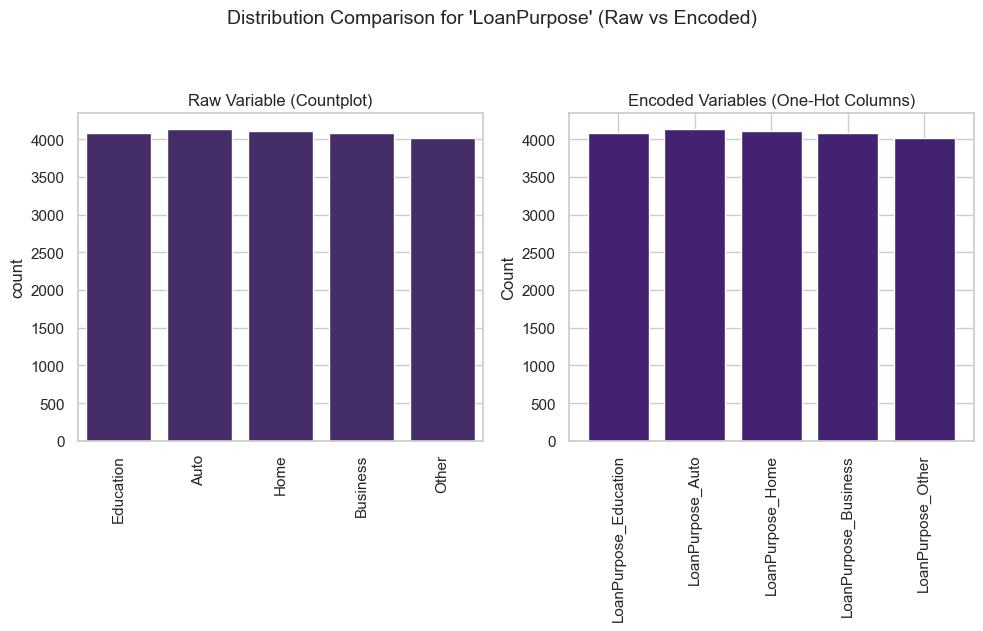

Count Table (Raw Variable):


LoanPurpose  Count
0        Auto   4137
1        Home   4110
2    Business   4082
3   Education   4080
4       Other   4018


Count Table (Encoded Variables):


Encoded Column  Count
0  LoanPurpose_Education   4080
1       LoanPurpose_Auto   4137
2       LoanPurpose_Home   4110
3   LoanPurpose_Business   4082
4      LoanPurpose_Other   4018

---


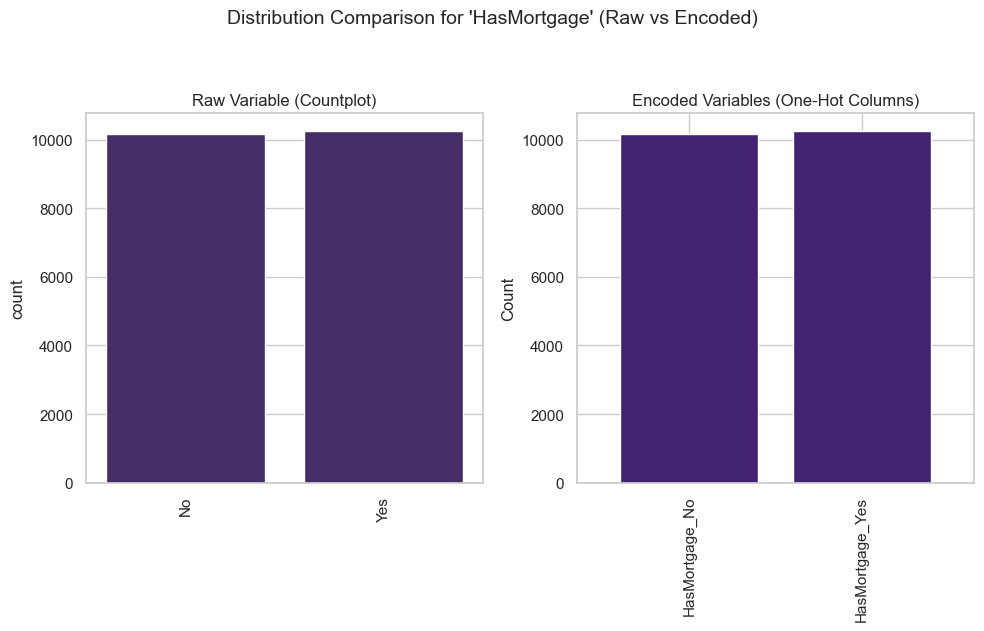

Count Table (Raw Variable):


HasMortgage  Count
0         Yes  10250
1          No  10177


Count Table (Encoded Variables):


Encoded Column  Count
0   HasMortgage_No  10177
1  HasMortgage_Yes  10250

---


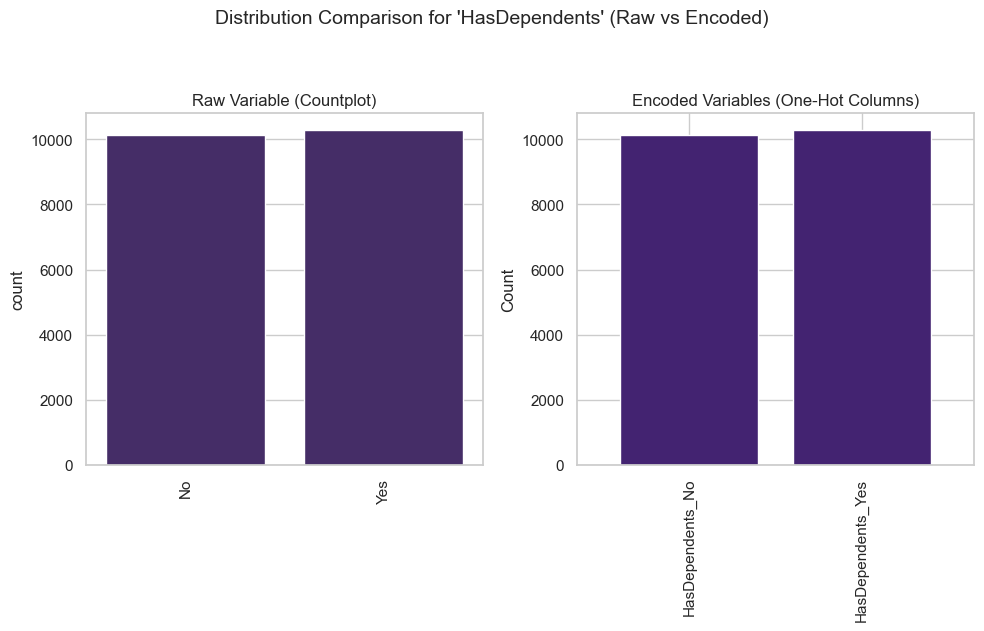

Count Table (Raw Variable):


HasDependents  Count
0           Yes  10285
1            No  10142


Count Table (Encoded Variables):


Encoded Column  Count
0   HasDependents_No  10142
1  HasDependents_Yes  10285

---


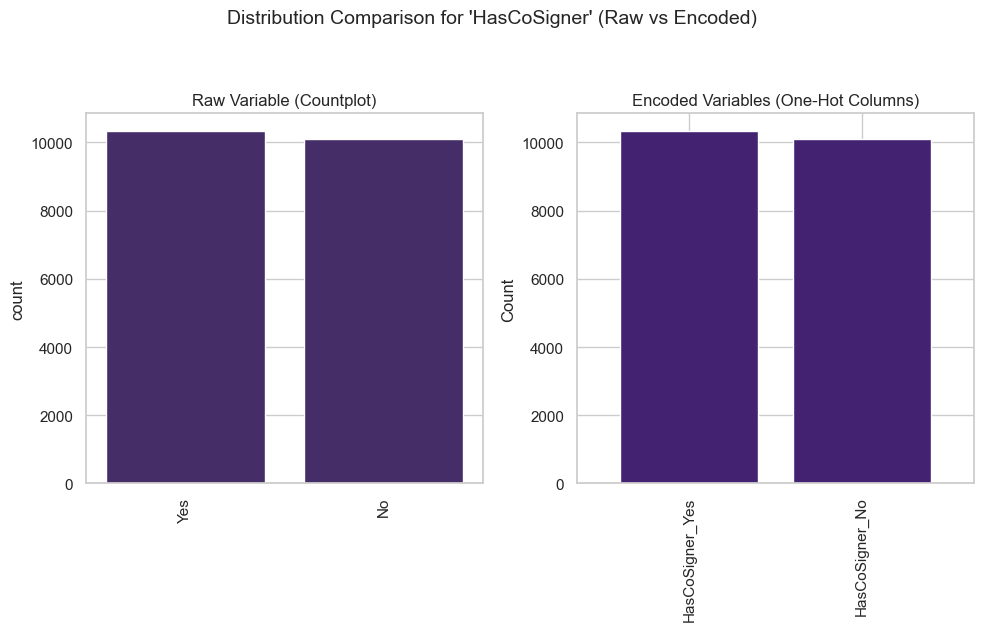

Count Table (Raw Variable):


HasCoSigner  Count
0         Yes  10336
1          No  10091


Count Table (Encoded Variables):


Encoded Column  Count
0  HasCoSigner_Yes  10336
1   HasCoSigner_No  10091

---


In [10]:
for var in variables_engineering:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Count tables
    raw_counts = df_engineering[var].value_counts().reset_index()
    raw_counts.columns = [var, "Count"]

    encoded_counts = (
        df_feat_eng.filter(like=var, axis=1)
        .sum()
        .reset_index()
    )
    encoded_counts.columns = ["Encoded Column", "Count"]

    # Create figure with 2 plots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle(f"Distribution Comparison for '{var}' (Raw vs Encoded)", fontsize=14, y=1.05)

    # Raw variable countplot
    sns.countplot(data=df_engineering, x=var, color="#432371", ax=axes[0])
    axes[0].set_title("Raw Variable (Countplot)")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis="x", rotation=90)

    # Encoded variable bar plot
    df_feat_eng.filter(like=var, axis=1).sum().plot(
        kind="bar", color="#432371", width=0.8, ax=axes[1]
    )
    axes[1].set_title("Encoded Variables (One-Hot Columns)")
    axes[1].tick_params(axis="x", rotation=90)
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # --- Show tables below the plots ---
    print("Count Table (Raw Variable):")
    display(raw_counts)

    print("\nCount Table (Encoded Variables):")
    display(encoded_counts)
    
    print("---")


* For nominal categorical variables, the OneHotEncoder successfully transformed each category into separate binary columns. Therefore, this transformation will be applied in the pipeline

* Step 4 - Apply the selected transformation to the Train and Test set

In [11]:
encoder = OneHotEncoder(variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.fit_transform(TestSet)

In [12]:
TrainSet.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   18  118130       50670          722               6               1   
1   31   16233      245996          633               9               1   
2   67   27978       90366          710              47               4   

   InterestRate  LoanTerm  DTIRatio    Education  ...  LoanPurpose_Auto  \
0          2.48        36      0.64  High School  ...                 0   
1          2.03        12      0.39          PhD  ...                 1   
2         13.90        48      0.76          PhD  ...                 0   

   LoanPurpose_Home  LoanPurpose_Business  LoanPurpose_Other  HasMortgage_No  \
0                 0                     0                  0               1   
1                 0                     0                  0               0   
2                 1                     0                  0               1   

   HasMortgage_Yes  HasDependents_No  HasDependents_Yes  HasCoSigner_Yes  \
0                0                 1                  0                1   
1                1                 0                  1                1   
2                0                 1                  0                1   

   HasCoSigner_No  
0               0  
1               0  
2               0  

[3 rows x 29 columns]

In [13]:
TestSet.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   62   63857      195239          414               5               3   
1   40  149331      182099          678              82               2   
2   53   76685       18866          597              19               1   

   InterestRate  LoanTerm  DTIRatio   Education  ...  LoanPurpose_Education  \
0         17.19        60      0.53  Bachelor's  ...                      0   
1         12.60        24      0.43    Master's  ...                      0   
2         18.69        60      0.28  Bachelor's  ...                      1   

   LoanPurpose_Auto  LoanPurpose_Other  LoanPurpose_Business  HasMortgage_Yes  \
0                 0                  0                     0                1   
1                 0                  0                     0                1   
2                 0                  0                     0                0   

   HasMortgage_No  HasDependents_Yes  HasDependents_No  HasCoSigner_No  \
0               0                  1                 0               1   
1               0                  0                 1               1   
2               1                  1                 0               1   

   HasCoSigner_Yes  
0                0  
1                0  
2                0  

[3 rows x 29 columns]

### Ordinal Variables: OrdinalEncoder

* Step 1: Select variables and create a separate DataFrame

In [14]:
variables_engineering= ["Education", "Default"]
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

Education  Default
0  High School        0
1          PhD        1
2          PhD        0

* Step 2: Create engineered variables by applying the encoder

In [15]:
# encoder = OrdinalEncoder(encoding_method='arbitrary', variables=variables_engineering)
# df_feat_eng = encoder.fit_transform(df_engineering)
# df_feat_eng.head(3)
encoder = OrdinalEncoder(encoding_method='ordered', variables="Education")
df_feat_eng = encoder.fit_transform(pd.DataFrame(df_engineering["Education"]), pd.DataFrame(df_engineering["Default"]))
df_feat_eng.head(3)


Education
0          3
1          1
2          1

* Step 3: Assess transformation by comparing engineered variables distribution to original ones

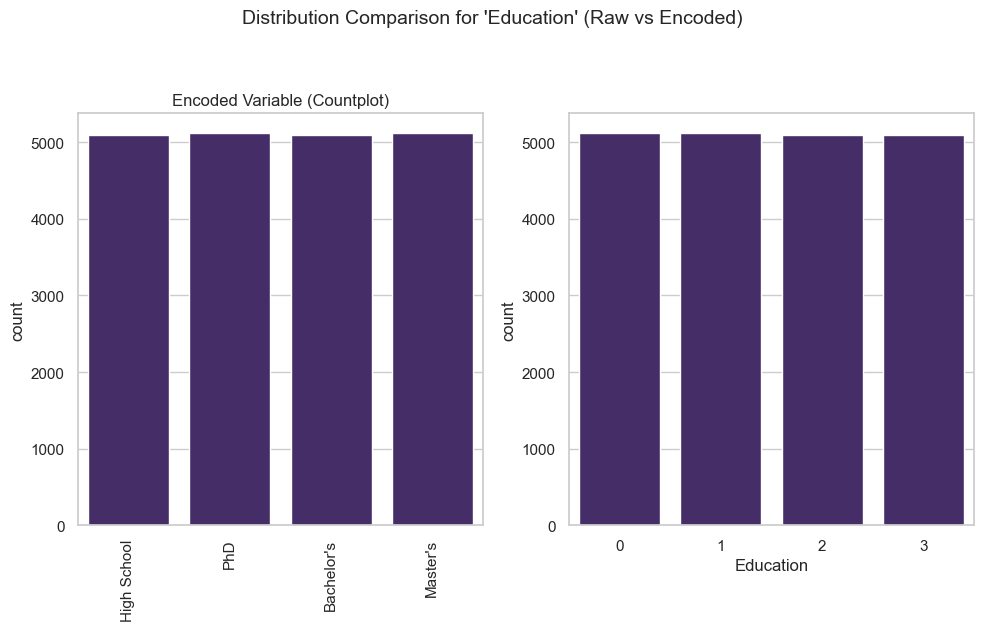

Count Table (Raw Variable):


Education  Count
0     Master's   5119
1          PhD   5114
2   Bachelor's   5099
3  High School   5095


Count Table (Encoded Variables):


Education  Count
0          0   5119
1          1   5114
2          2   5099
3          3   5095

Class Mapping:
{'Education': {"Master's": 0, 'PhD': 1, "Bachelor's": 2, 'High School': 3}}
---


In [16]:
#for var in variables_engineering:
import matplotlib.pyplot as plt
import seaborn as sns

var = variables_engineering[0]
# Count tables
raw_counts = df_engineering[var].value_counts().reset_index()
raw_counts.columns = [var, "Count"]

encoded_counts = df_feat_eng[var].value_counts().reset_index()
encoded_counts.columns = [var, "Count"]

# Create figure with 2 plots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle(f"Distribution Comparison for '{var}' (Raw vs Encoded)", fontsize=14, y=1.05)

# Raw variable countplot
sns.countplot(data=df_engineering, x=var, color="#432371", ax=axes[0])
axes[0].set_title("Raw Variable (Countplot)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=90)

# Encoded variable bar plot
sns.countplot(data=df_feat_eng, x=var, color="#432371", ax=axes[1])
axes[0].set_title("Encoded Variable (Countplot)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

# Show tables below the plots
print("Count Table (Raw Variable):")
display(raw_counts)

print("\nCount Table (Encoded Variables):")
display(encoded_counts)
print("Class Mapping:")
print(encoder.encoder_dict_)

print("---")

* The OrdinalEncoder successfully transformed the ordered categorical variables into numeric form while preserving their order. Therefore, this transformation will be applied in the pipeline

* Step 4 - Apply the selected transformation to the Train and Test set

In [17]:
encoder = OrdinalEncoder(encoding_method='ordered', variables="Education")
TrainSet["Education"] = encoder.fit_transform(pd.DataFrame(TrainSet["Education"]), pd.DataFrame(TrainSet["Default"]))
TestSet["Education"] = encoder.transform(pd.DataFrame(TestSet["Education"]))

In [18]:
TestSet.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   62   63857      195239          414               5               3   
1   40  149331      182099          678              82               2   
2   53   76685       18866          597              19               1   

   InterestRate  LoanTerm  DTIRatio  Education  ...  LoanPurpose_Education  \
0         17.19        60      0.53          2  ...                      0   
1         12.60        24      0.43          0  ...                      0   
2         18.69        60      0.28          2  ...                      1   

   LoanPurpose_Auto  LoanPurpose_Other  LoanPurpose_Business  HasMortgage_Yes  \
0                 0                  0                     0                1   
1                 0                  0                     0                1   
2                 0                  0                     0                0   

   HasMortgage_No  HasDependents_Yes  HasDependents_No  HasCoSigner_No  \
0               0                  1                 0               1   
1               0                  0                 1               1   
2               1                  1                 0               1   

   HasCoSigner_Yes  
0                0  
1                0  
2                0  

[3 rows x 29 columns]

In [19]:
TrainSet.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   18  118130       50670          722               6               1   
1   31   16233      245996          633               9               1   
2   67   27978       90366          710              47               4   

   InterestRate  LoanTerm  DTIRatio  Education  ...  LoanPurpose_Auto  \
0          2.48        36      0.64          3  ...                 0   
1          2.03        12      0.39          1  ...                 1   
2         13.90        48      0.76          1  ...                 0   

   LoanPurpose_Home  LoanPurpose_Business  LoanPurpose_Other  HasMortgage_No  \
0                 0                     0                  0               1   
1                 0                     0                  0               0   
2                 1                     0                  0               1   

   HasMortgage_Yes  HasDependents_No  HasDependents_Yes  HasCoSigner_Yes  \
0                0                 1                  0                1   
1                1                 0                  1                1   
2                0                 1                  0                1   

   HasCoSigner_No  
0               0  
1               0  
2               0  

[3 rows x 29 columns]

## Numerical Variables

### Custom function

It gets a DataFrame as input and applies a defined set of numerical
feature engineering transformers. This will help you to decide which transformers to apply to your data.


In [20]:
# TODO FUNKTION VEREINFACHEN??

import scipy.stats as stats
# for vs code
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):

    df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
        df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    sns.histplot(data=df, x=variable, kde=True, ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


### Numerical Transformations

* Step 1: Select variables and create a separate DataFrame

In [21]:
variables_engineering= TrainSet.select_dtypes(include=['int64', 'float64']).columns.drop(["NumCreditLines", "LoanTerm", "Default"]).tolist()
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  InterestRate  \
0   18  118130       50670          722               6          2.48   
1   31   16233      245996          633               9          2.03   
2   67   27978       90366          710              47         13.90   

   DTIRatio  Education  
0      0.64          3  
1      0.39          1  
2      0.76          1

* Step 2: Create engineered variables by applying the encoder and assess transformation by comparing engineered variables distributions to original ones

* Variable Analyzed: Age
* Applied transformation: ['Age_log_e', 'Age_log_10', 'Age_reciprocal', 'Age_power', 'Age_box_cox', 'Age_yeo_johnson'] 



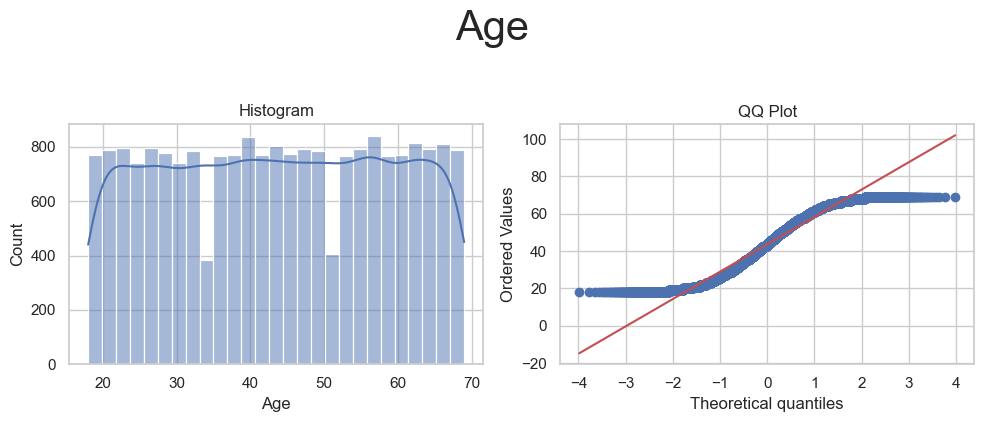

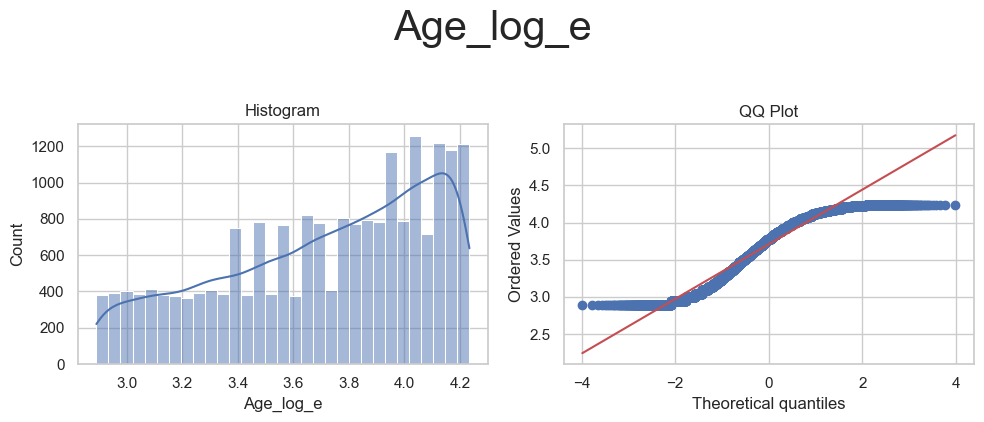

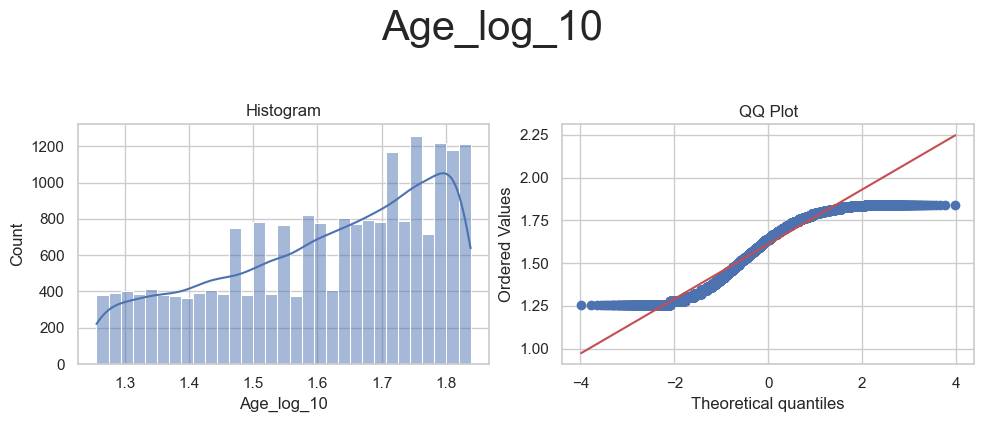

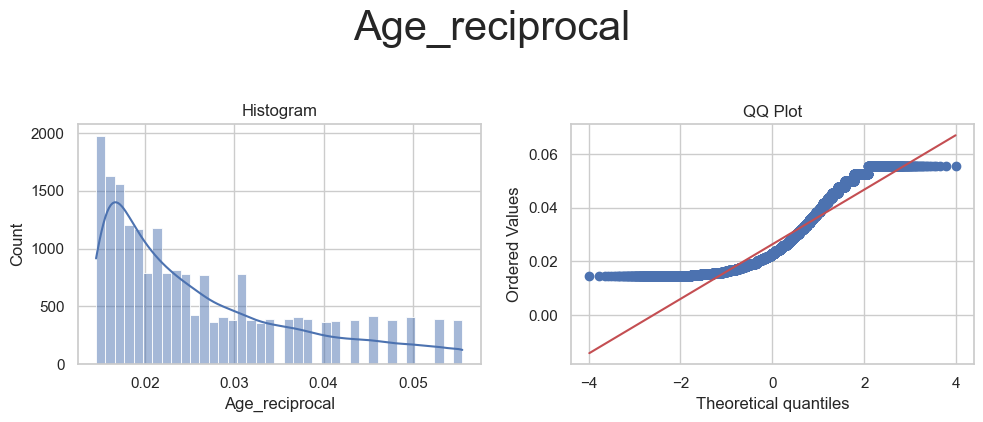

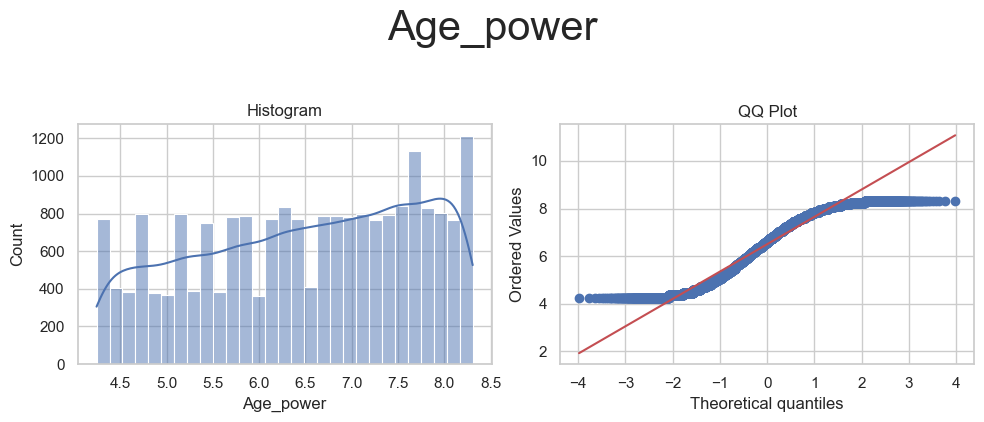

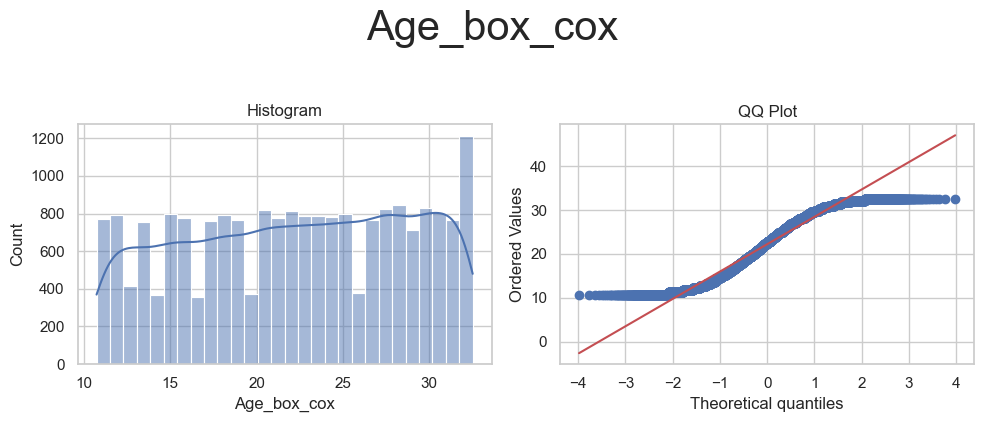

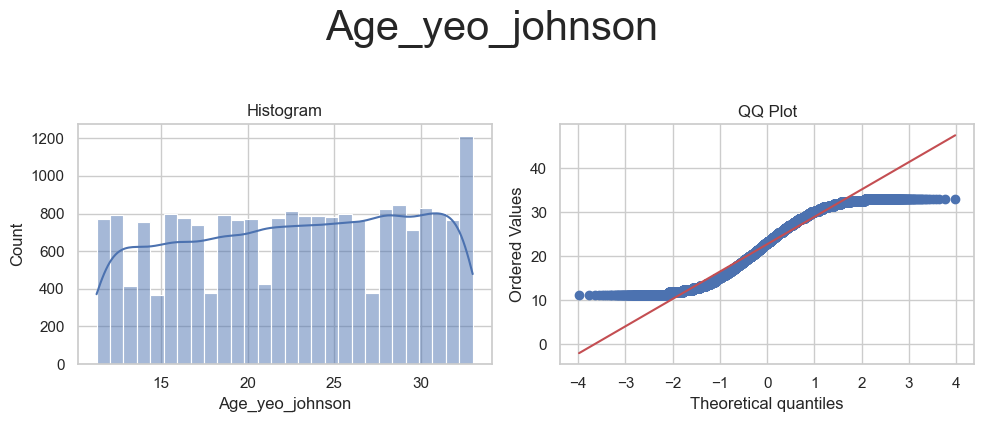



* Variable Analyzed: Income
* Applied transformation: ['Income_log_e', 'Income_log_10', 'Income_reciprocal', 'Income_power', 'Income_box_cox', 'Income_yeo_johnson'] 



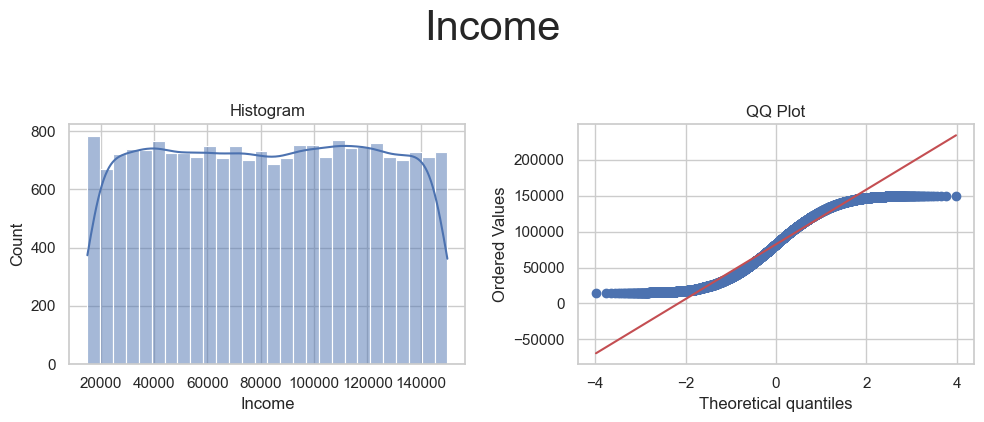

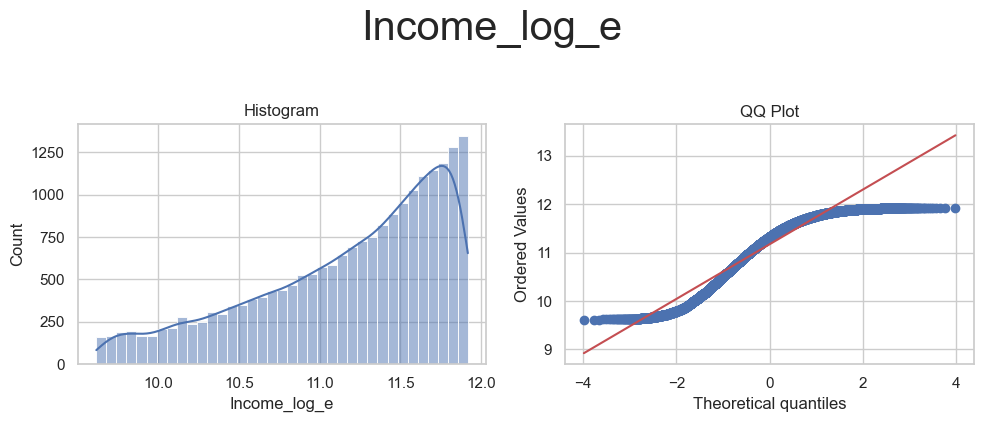

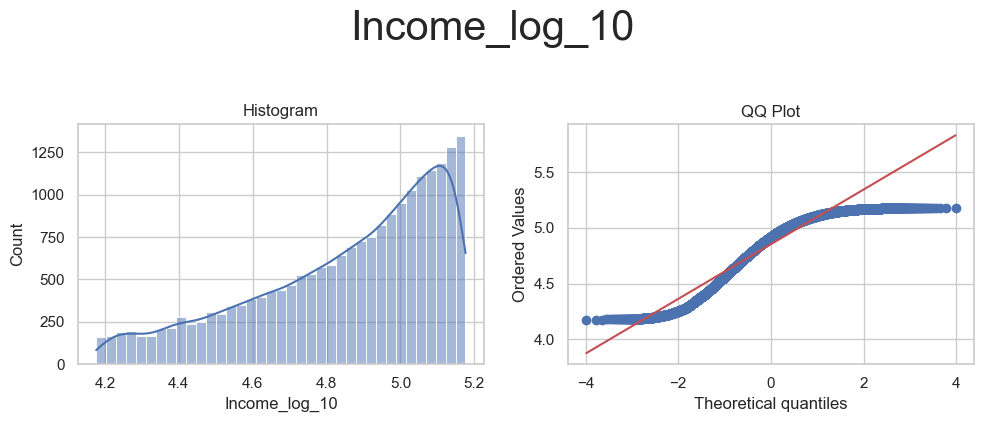

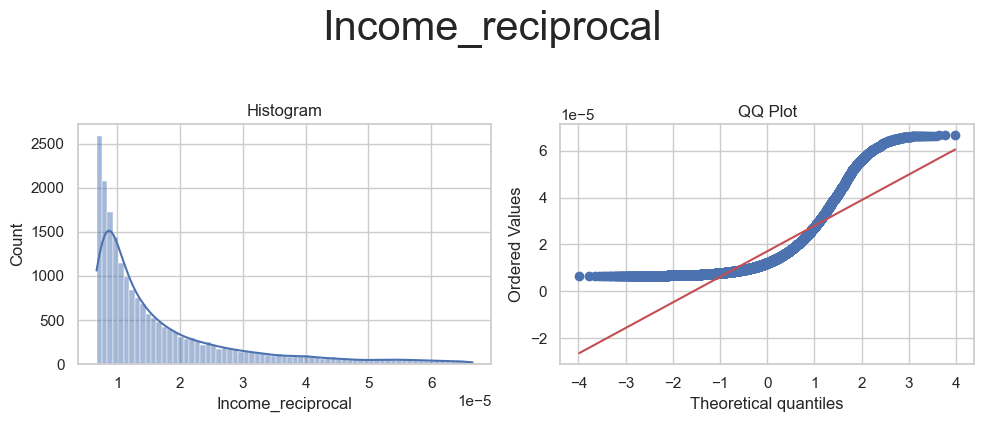

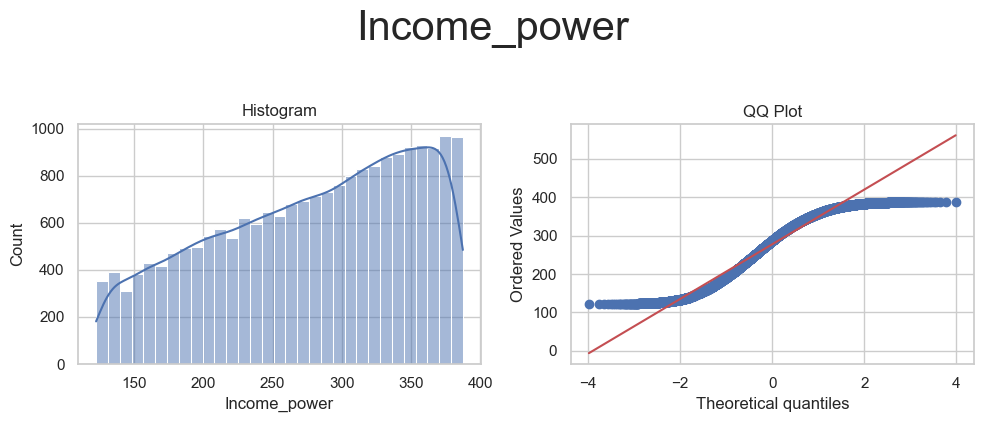

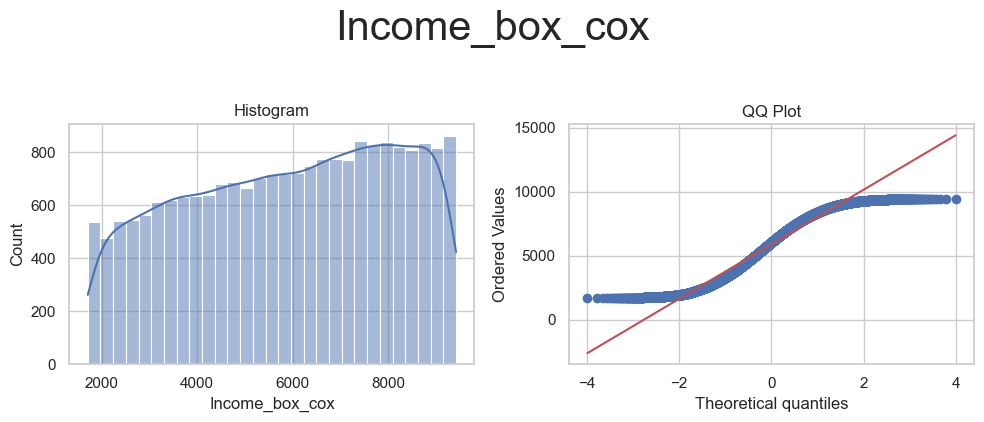

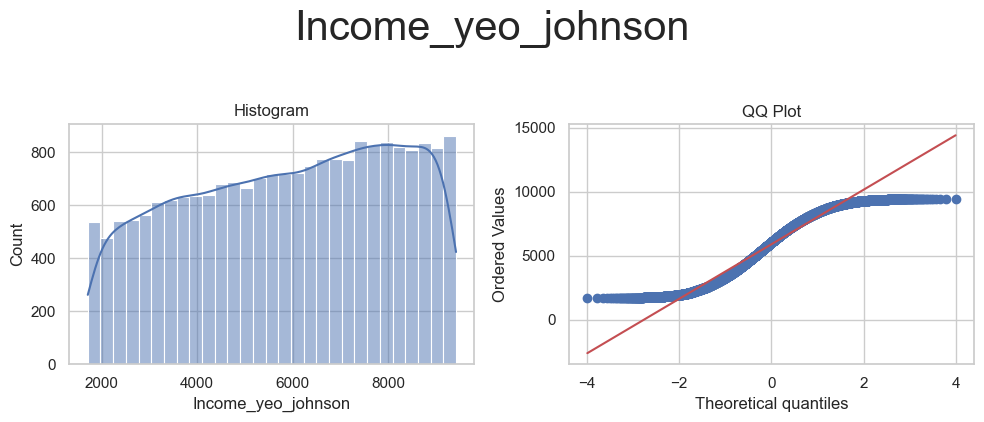



* Variable Analyzed: LoanAmount
* Applied transformation: ['LoanAmount_log_e', 'LoanAmount_log_10', 'LoanAmount_reciprocal', 'LoanAmount_power', 'LoanAmount_box_cox', 'LoanAmount_yeo_johnson'] 



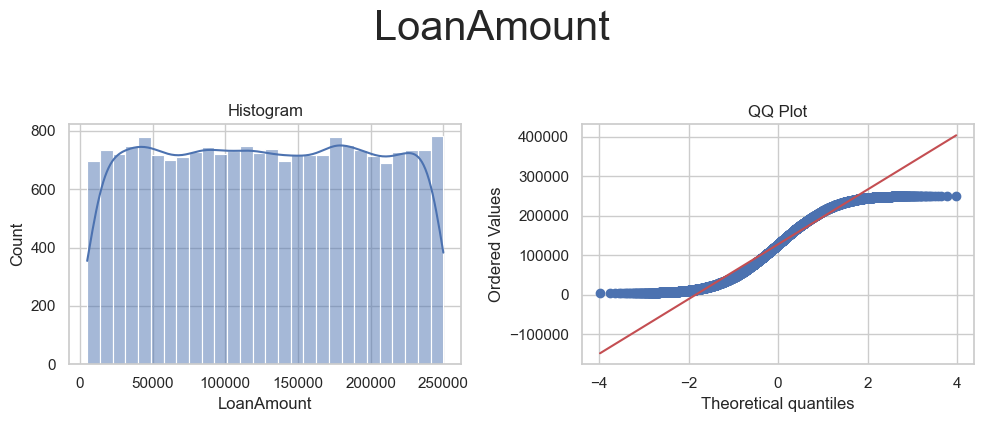

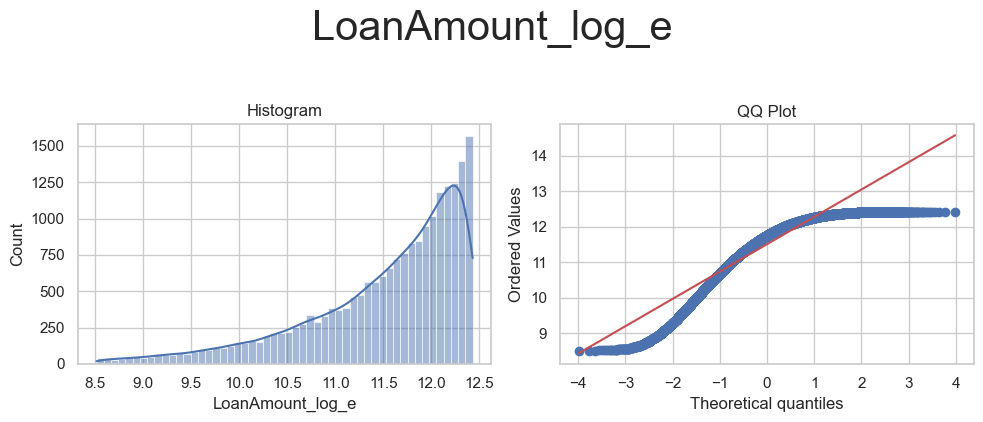

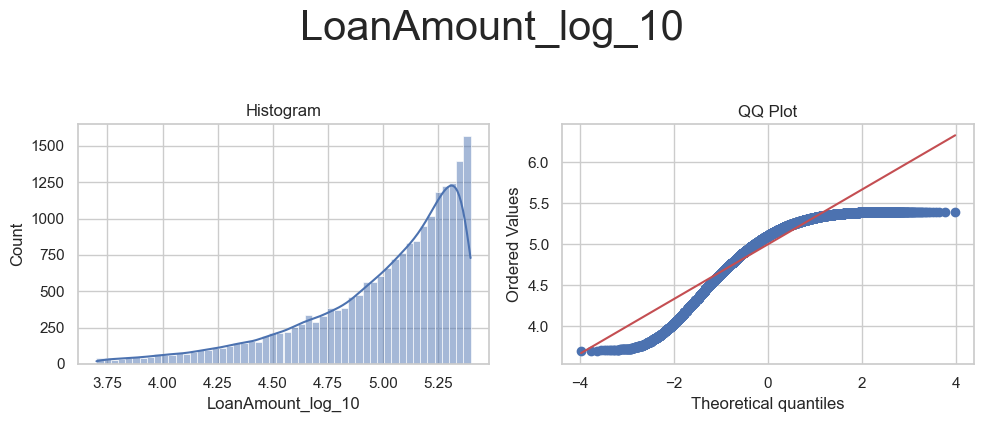

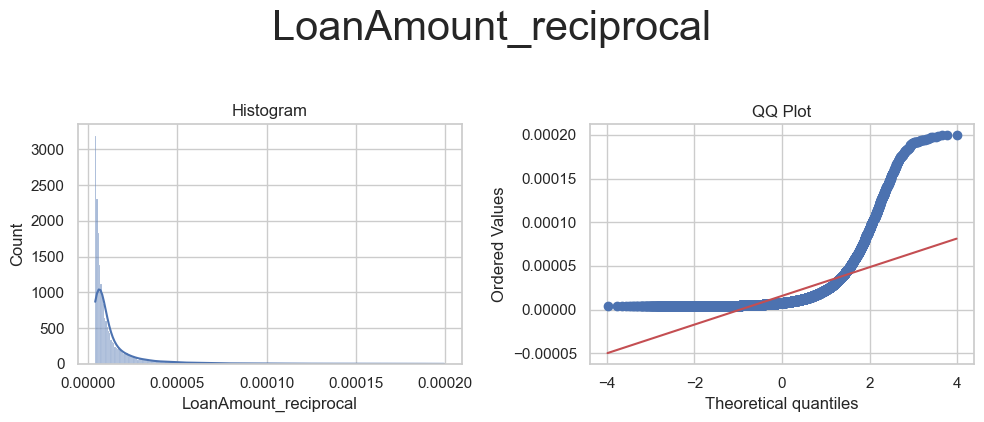

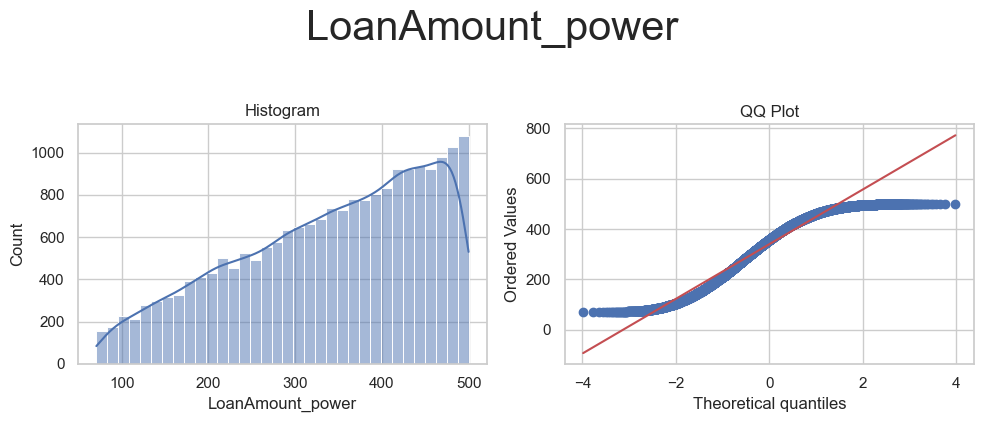

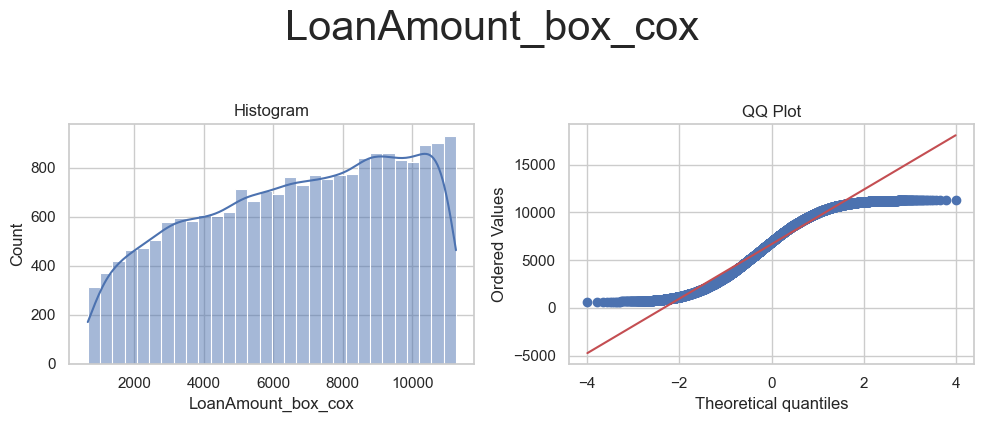

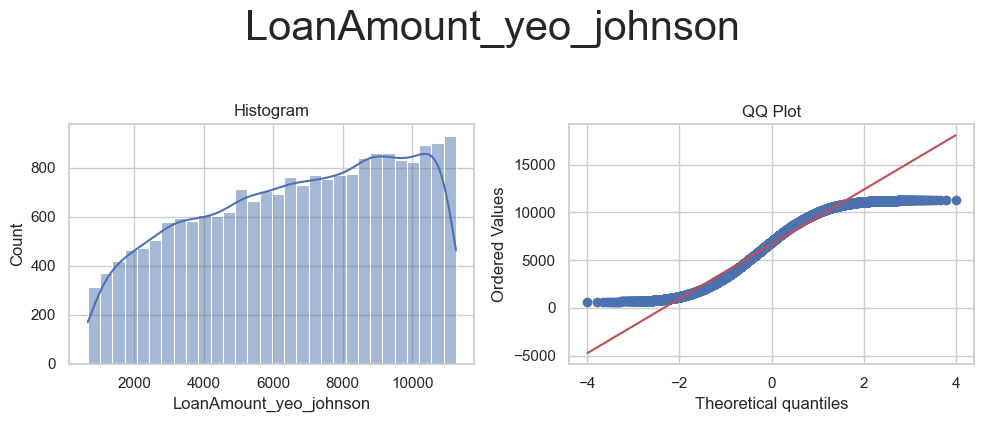



* Variable Analyzed: CreditScore
* Applied transformation: ['CreditScore_log_e', 'CreditScore_log_10', 'CreditScore_reciprocal', 'CreditScore_power', 'CreditScore_box_cox', 'CreditScore_yeo_johnson'] 



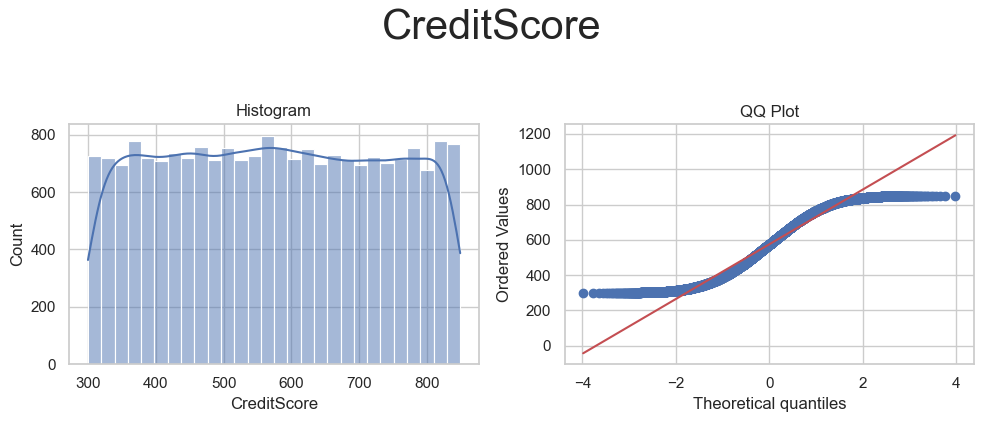

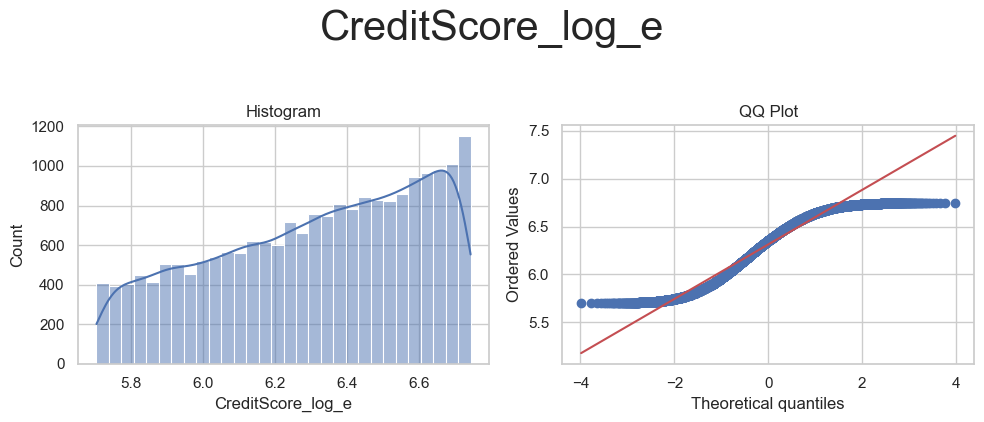

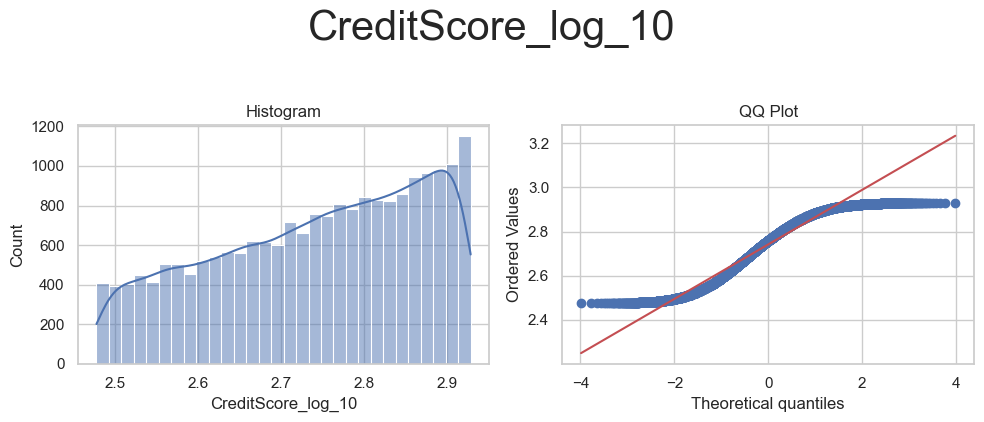

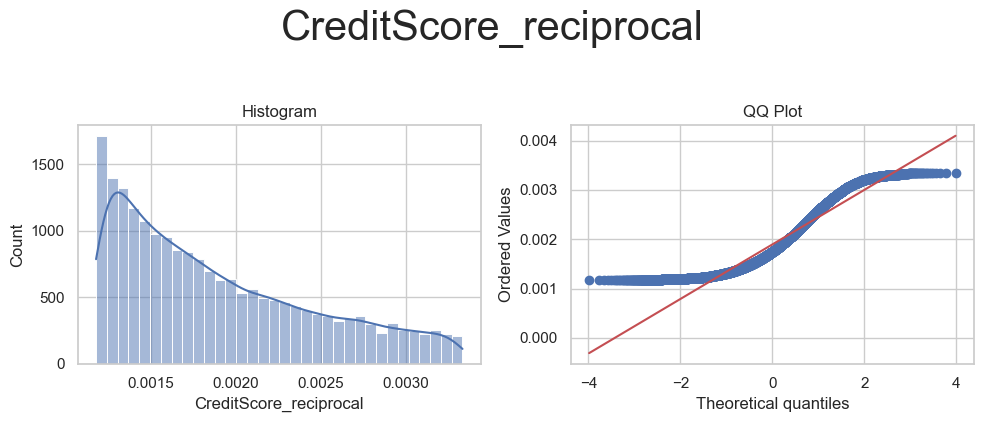

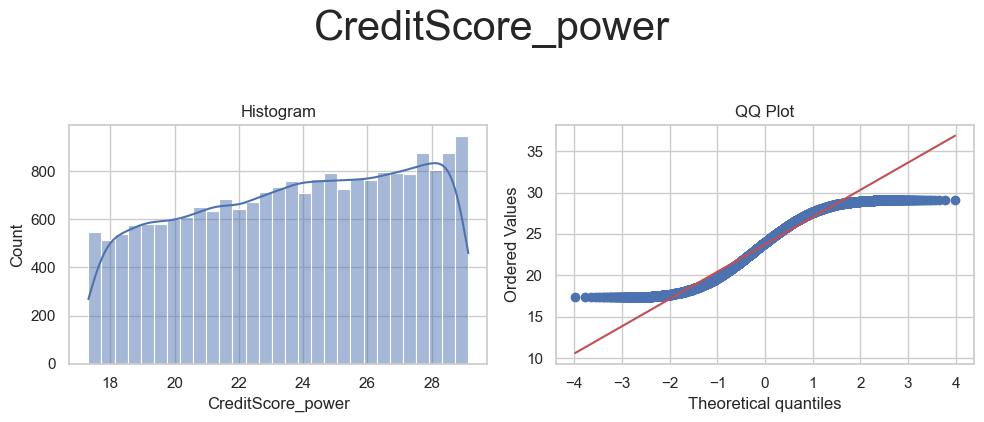

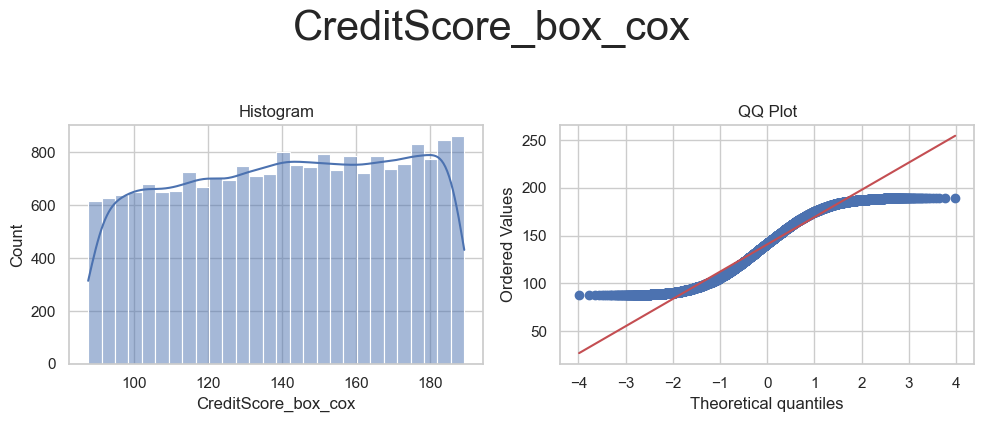

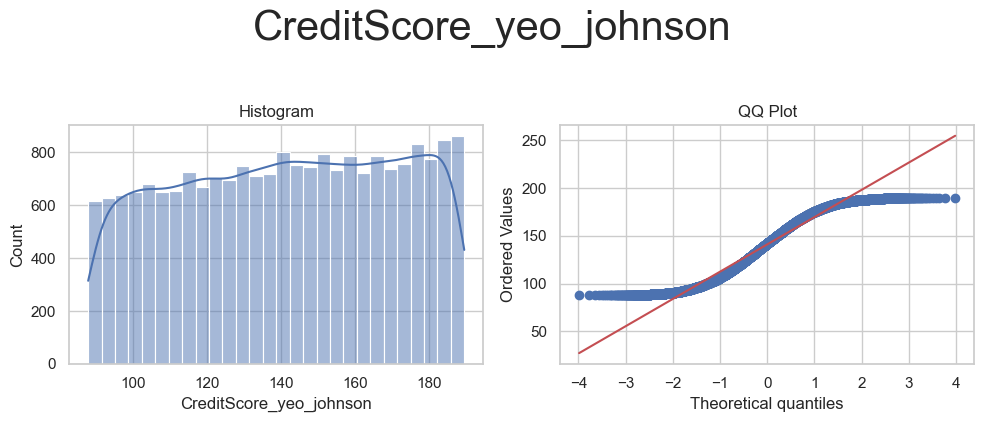



* Variable Analyzed: MonthsEmployed
* Applied transformation: ['MonthsEmployed_power', 'MonthsEmployed_yeo_johnson'] 



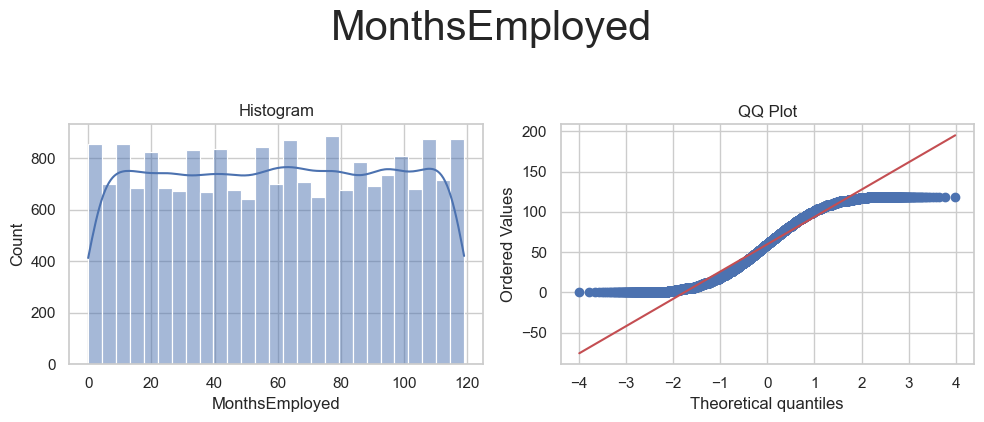

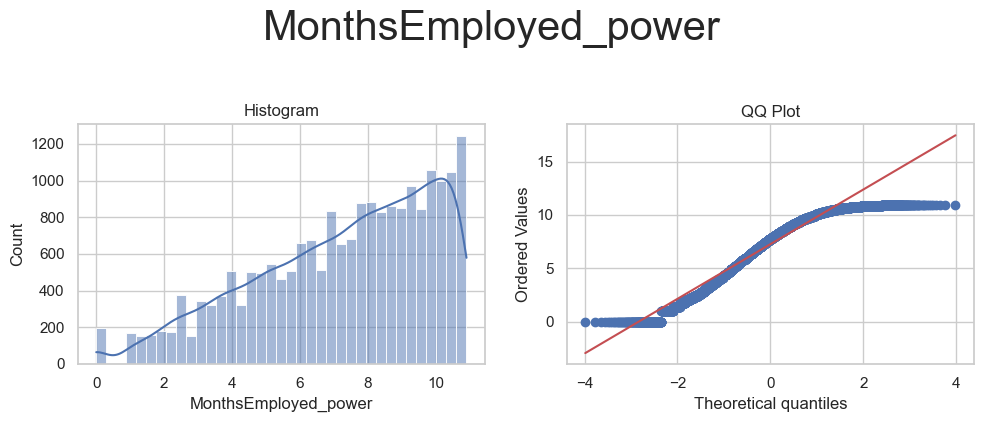

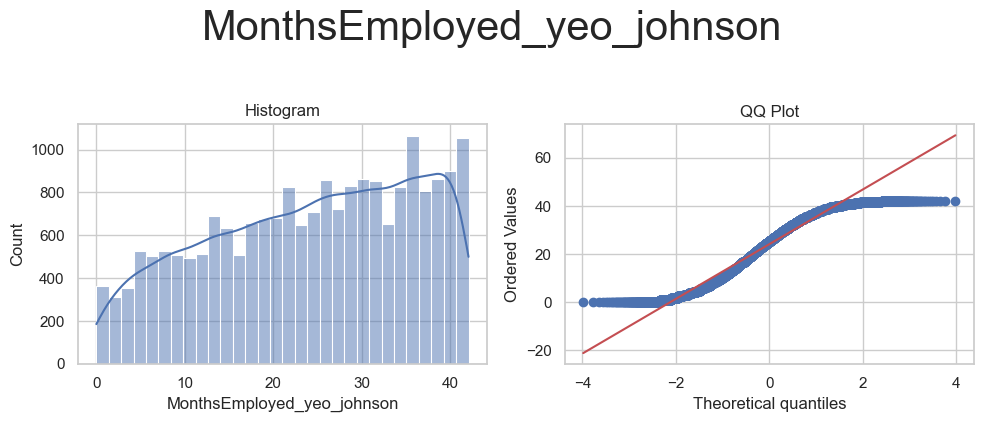



* Variable Analyzed: InterestRate
* Applied transformation: ['InterestRate_log_e', 'InterestRate_log_10', 'InterestRate_reciprocal', 'InterestRate_power', 'InterestRate_box_cox', 'InterestRate_yeo_johnson'] 



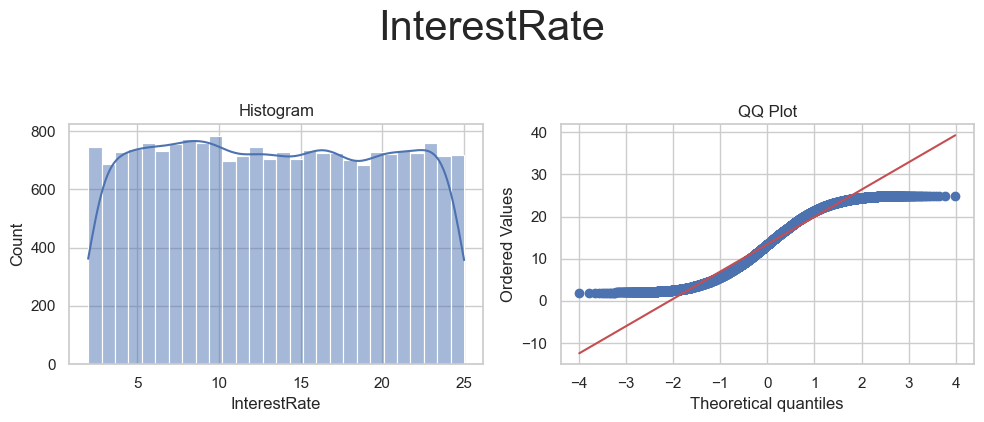

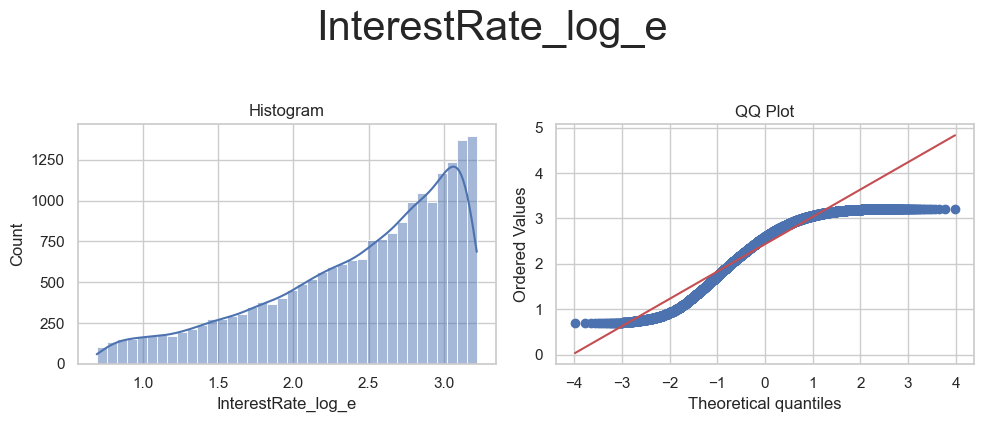

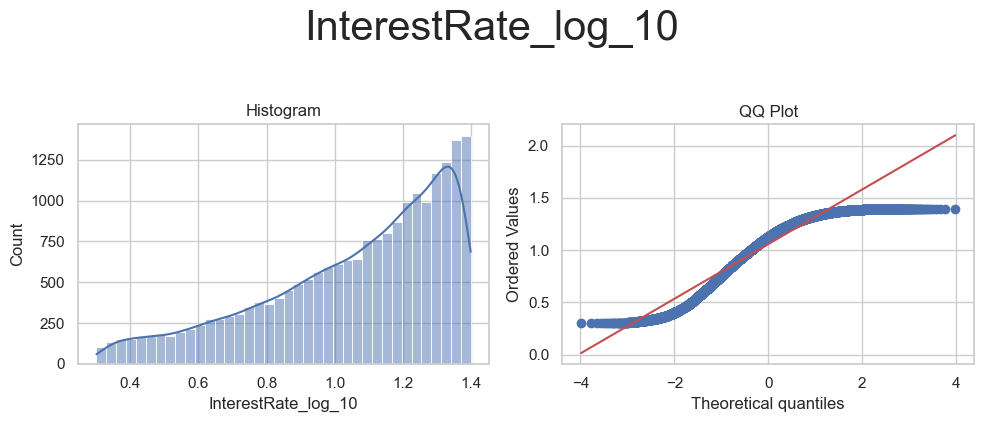

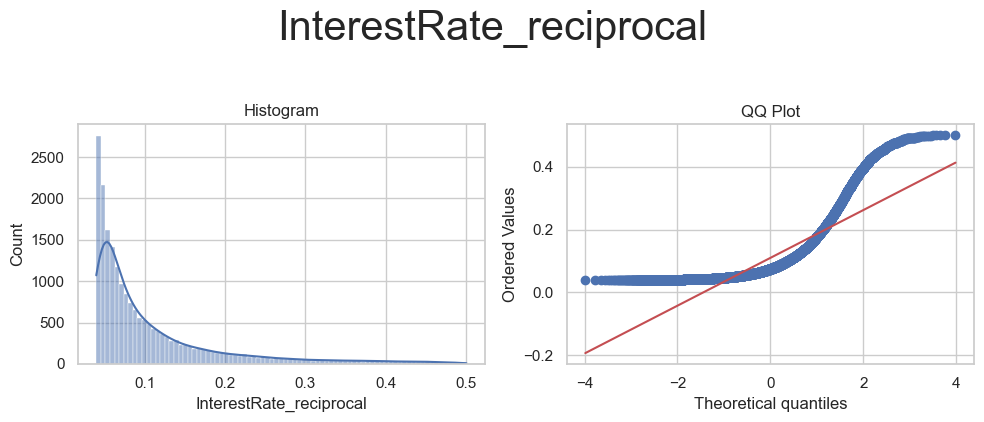

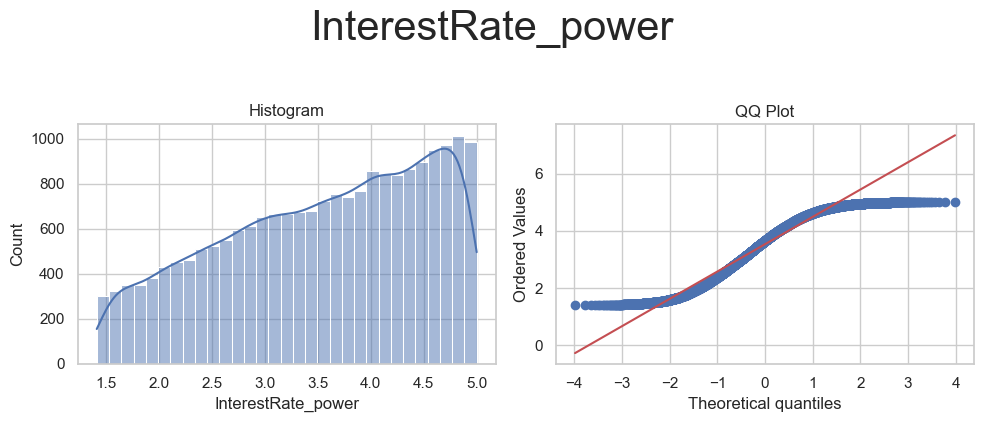

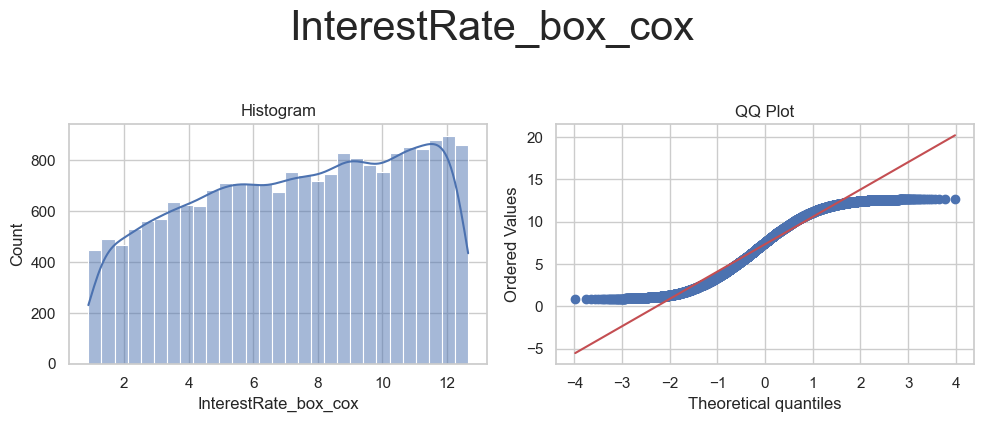

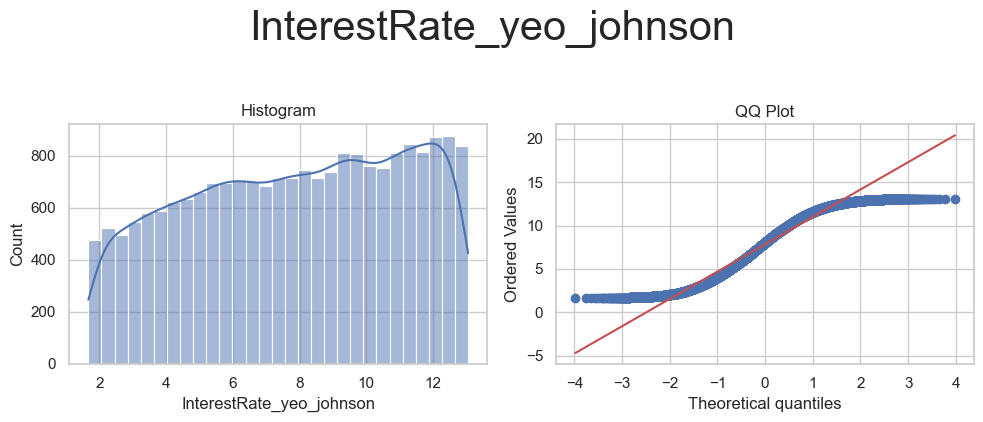



* Variable Analyzed: DTIRatio
* Applied transformation: ['DTIRatio_log_e', 'DTIRatio_log_10', 'DTIRatio_reciprocal', 'DTIRatio_power', 'DTIRatio_box_cox', 'DTIRatio_yeo_johnson'] 



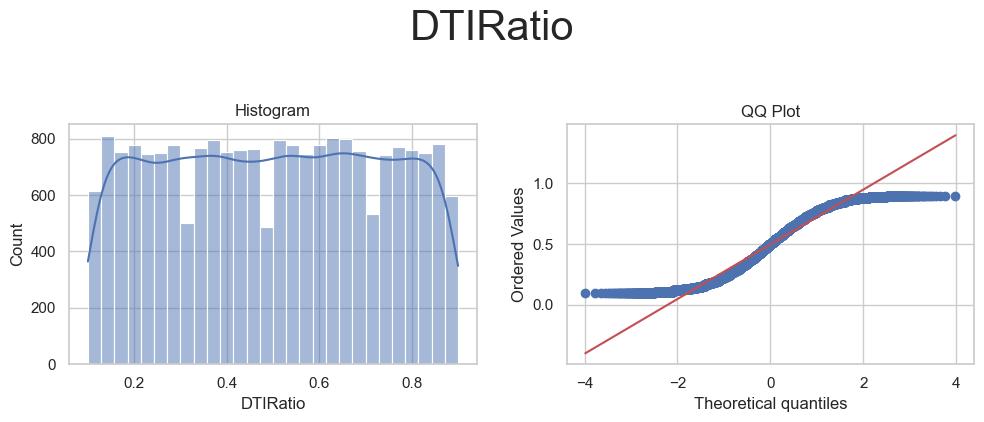

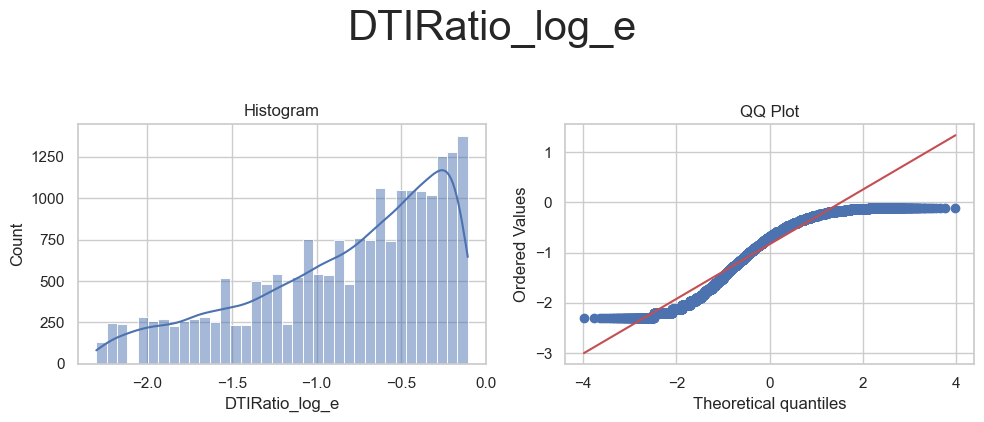

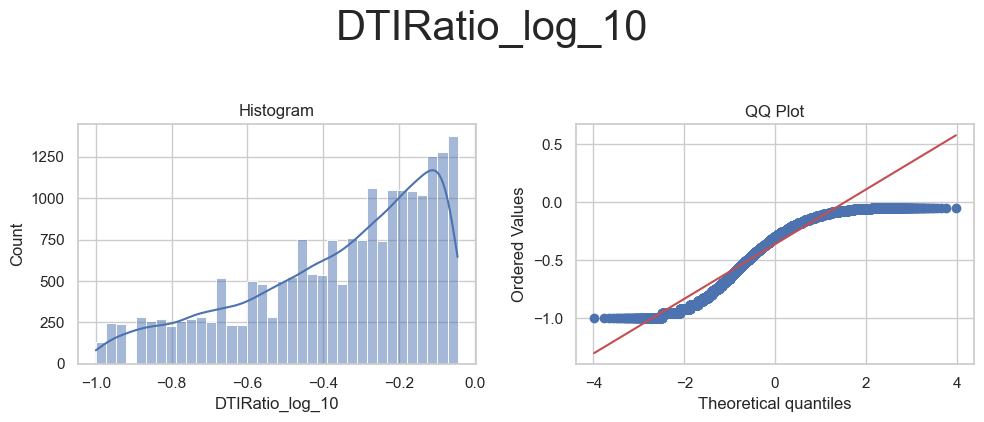

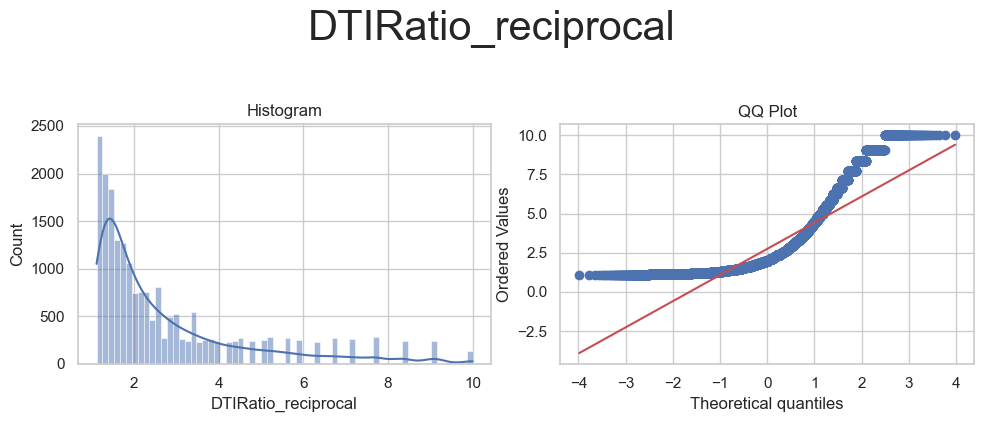

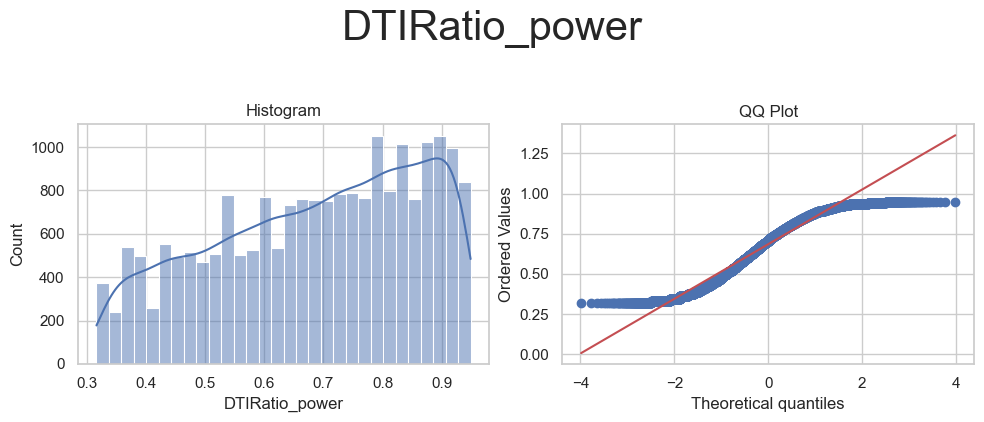

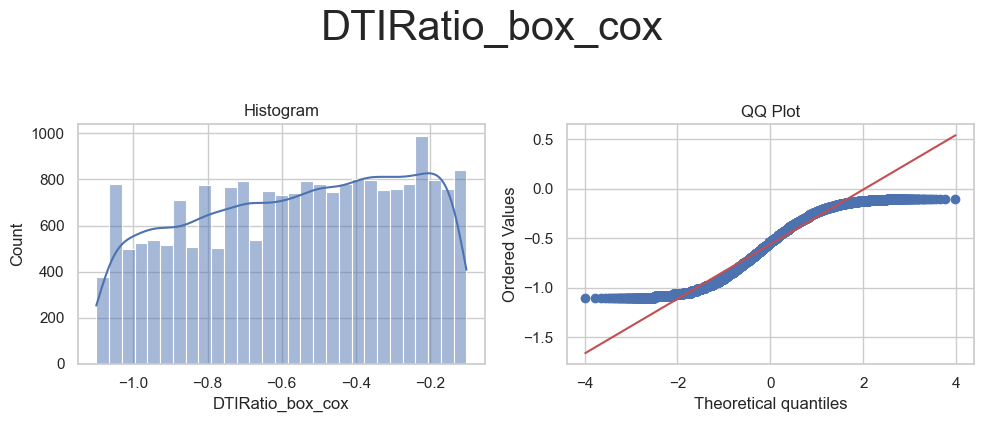

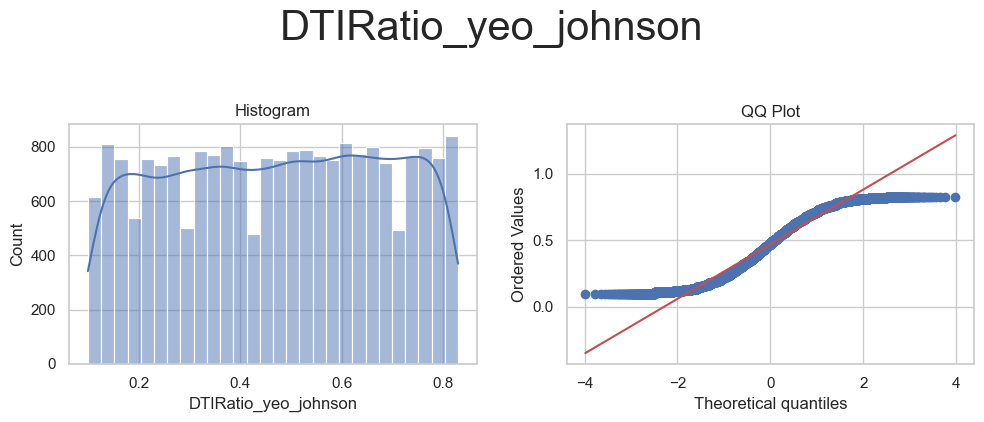



* Variable Analyzed: Education
* Applied transformation: ['Education_power', 'Education_yeo_johnson'] 



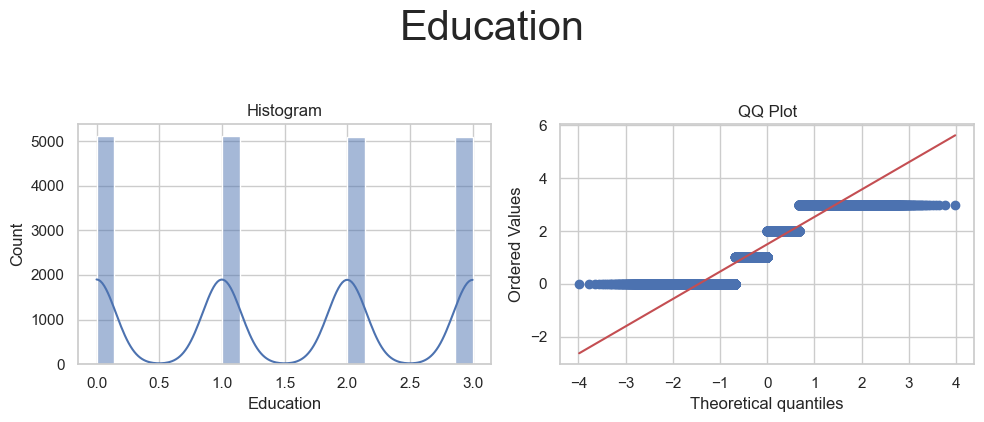

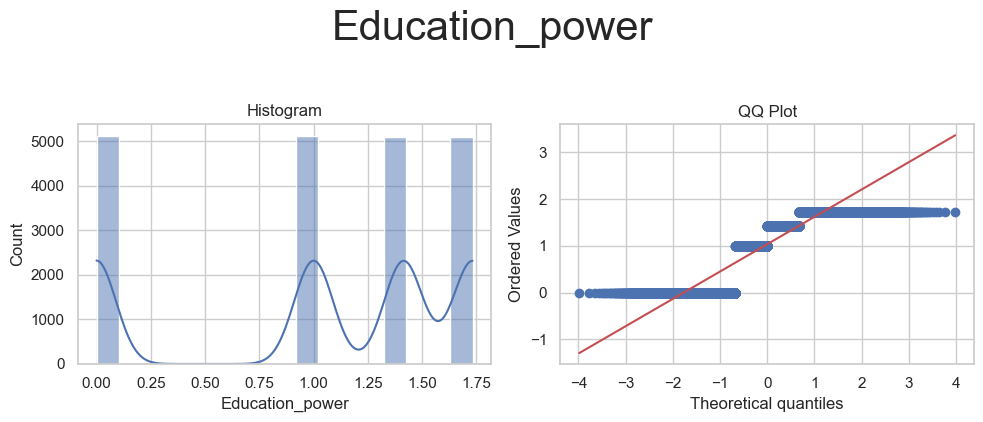

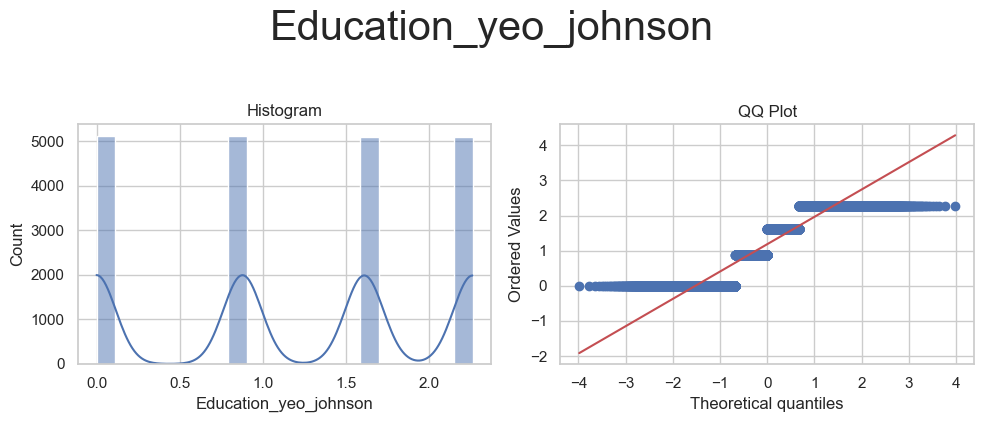

In [22]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* Several numerical transformers were tested, including Log, Log base 10, Reciprocal, Power, Box-Cox and Yeo-Johnson. None of them helped to achieve a bell-shaped distribution or values aligned along the diagonal in the QQ plot. Therefore, no numerical transformation will be applied

### SmartCorrelatedSelection Variables

Here we're looking for groups of features that correlate amongst themselves,
we want to remove any surplus correlated features since they’ll add the same information to the model.
The transformer takes care of finding the groups and drops the features based on the method,
threshold and selection method that we decided. This means for every group of correlated features,
the transformer will remove all but one feature.

* Step 1: Create a separate DataFrame

In [23]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   18  118130       50670          722               6               1   
1   31   16233      245996          633               9               1   
2   67   27978       90366          710              47               4   

   InterestRate  LoanTerm  DTIRatio  Education  ...  LoanPurpose_Auto  \
0          2.48        36      0.64          3  ...                 0   
1          2.03        12      0.39          1  ...                 1   
2         13.90        48      0.76          1  ...                 0   

   LoanPurpose_Home  LoanPurpose_Business  LoanPurpose_Other  HasMortgage_No  \
0                 0                     0                  0               1   
1                 0                     0                  0               0   
2                 1                     0                  0               1   

   HasMortgage_Yes  HasDependents_No  HasDependents_Yes  HasCoSigner_Yes  \
0                0                 1                  0                1   
1                1                 0                  1                1   
2                0                 1                  0                1   

   HasCoSigner_No  
0               0  
1               0  
2               0  

[3 rows x 29 columns]

Confirm that all data types are numerical

In [24]:
df_engineering.dtypes

Age                               int64
Income                            int64
LoanAmount                        int64
CreditScore                       int64
MonthsEmployed                    int64
NumCreditLines                    int64
InterestRate                    float64
LoanTerm                          int64
DTIRatio                        float64
Education                         int64
Default                           int64
EmploymentType_Part-time          int32
EmploymentType_Self-employed      int32
EmploymentType_Full-time          int32
EmploymentType_Unemployed         int32
MaritalStatus_Divorced            int32
MaritalStatus_Single              int32
MaritalStatus_Married             int32
LoanPurpose_Education             int32
LoanPurpose_Auto                  int32
LoanPurpose_Home                  int32
LoanPurpose_Business              int32
LoanPurpose_Other                 int32
HasMortgage_No                    int32
HasMortgage_Yes                   int32


* Step 2: Create engineered variables applying the transformations

In [30]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'HasMortgage_No', 'HasMortgage_Yes'},
 {'HasDependents_No', 'HasDependents_Yes'},
 {'HasCoSigner_No', 'HasCoSigner_Yes'}]

In [31]:
corr_sel.features_to_drop_

['HasMortgage_Yes', 'HasDependents_No', 'HasCoSigner_No']

* After applying the `SmartCorrelatedSelection`, only the binary categorical variables showed high correlation, which is expected given their one-hot encoding. No other features were flagged for removal, which aligns with our earlier observations in the exploratory data analysis that overall correlation rates are very low. This confirms that multicollinearity is not a major concern for this dataset
* Since the high correlation between dummy variables created by one-hot encoding can be resolved by setting ``drop_last=True`` in the `OneHotEncoder`, we will apply this parameter and omit the `SmartCorrelatedSelection` step. This simplifies the pipeline without affecting model correctness.

## Scaling TO DO noch anwendung auf train test ergänzen wie bei encodern

We apply scaling to the dataset so that all numerical variables are on a comparable range. This is important because many machine learning algorithms are sensitive to the magnitude of features. Without scaling, variables with larger ranges could dominate the learning process, leading to biased or suboptimal models.

Note that after scaling, the especially categorical values are standardized and lose their original interpretability, but this ensures that all numerical inputs contribute comparably to the model.

In [ ]:
from sklearn.preprocessing import StandardScaler

df_engineering = TrainSet.copy()
scaler = StandardScaler()
scaled_array  = scaler.fit_transform(df_engineering)
df_engineering = pd.DataFrame(scaled_array, columns=df_engineering.columns)
df_engineering

['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education']


Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
0     -1.708650  0.915389   -1.089723     0.928845       -1.543849   
1     -0.842661 -1.698677    1.668269     0.367586       -1.457626   
2      1.555459 -1.397371   -0.529218     0.853170       -0.365480   
3     -1.642035 -1.358839   -0.056073     0.632450        1.502666   
4     -0.842661  1.206895    0.916622    -0.483763        1.646369   
...         ...       ...         ...          ...             ...   
20422  1.622074  0.231171    0.089066    -0.754933       -1.285182   
20423  0.156556  0.425449    0.767388     0.487405        1.186518   
20424 -1.642035  1.666666   -0.378106    -0.723402       -1.428886   
20425  1.422231 -1.432902    0.279897    -0.748627       -0.394220   
20426  0.089941  1.677774    1.153413    -0.862140        0.841630   

       NumCreditLines  InterestRate  LoanTerm  DTIRatio  Education  ...  \
0           -1.349353     -1.651482 -0.004386  0.610110   1.343522  ...   
1           -1.349353     -1.719270 -1.426537 -0.475322  -0.445301  ...   
2            1.335726      0.068824  0.706689  1.131118  -0.445301  ...   
3            0.440700     -0.116463 -0.004386  0.783779   0.449110  ...   
4           -0.454327      0.603595 -0.715462 -1.604172  -1.339712  ...   
...               ...           ...       ...       ...        ...  ...   
20422       -0.454327      0.663851 -1.426537 -0.258236   1.343522  ...   
20423       -1.349353      1.201635  0.706689  1.000866   1.343522  ...   
20424        1.335726      0.546352  1.417765 -0.648992   0.449110  ...   
20425       -1.349353      1.728874 -1.426537 -1.300251   1.343522  ...   
20426       -0.454327     -0.946488 -0.715462 -1.169999   1.343522  ...   

       LoanPurpose_Auto  LoanPurpose_Home  LoanPurpose_Business  \
0             -0.503944         -0.501881              -0.49974   
1              1.984348         -0.501881              -0.49974   
2             -0.503944          1.992504              -0.49974   
3             -0.503944         -0.501881              -0.49974   
4             -0.503944         -0.501881              -0.49974   
...                 ...               ...                   ...   
20422         -0.503944         -0.501881              -0.49974   
20423         -0.503944          1.992504              -0.49974   
20424         -0.503944         -0.501881              -0.49974   
20425         -0.503944         -0.501881              -0.49974   
20426         -0.503944         -0.501881              -0.49974   

       LoanPurpose_Other  HasMortgage_No  HasMortgage_Yes  HasDependents_No  \
0              -0.494839        1.003580        -1.003580          1.007025   
1              -0.494839       -0.996433         0.996433         -0.993024   
2              -0.494839        1.003580        -1.003580          1.007025   
3              -0.494839        1.003580        -1.003580         -0.993024   
4              -0.494839       -0.996433         0.996433         -0.993024   
...                  ...             ...              ...               ...   
20422           2.020859       -0.996433         0.996433         -0.993024   
20423          -0.494839       -0.996433         0.996433         -0.993024   
20424          -0.494839       -0.996433         0.996433          1.007025   
20425          -0.494839       -0.996433         0.996433         -0.993024   
20426          -0.494839        1.003580        -1.003580          1.007025   

       HasDependents_Yes  HasCoSigner_Yes  HasCoSigner_No  
0              -1.007025         0.988077       -0.988077  
1               0.993024         0.988077       -0.988077  
2              -1.007025         0.988077       -0.988077  
3               0.993024        -1.012067        1.012067  
4               0.993024        -1.012067        1.012067  
...                  ...              ...             ...  
20422           0.993024        -1.012067        1.012067  
20423           0.993024         0.9

In [40]:
df_engineering.describe().round(2).T

count  mean  std   min   25%   50%   75%   max
Age                           20427.0  -0.0  1.0 -1.71 -0.84  0.02  0.89  1.69
Income                        20427.0   0.0  1.0 -1.73 -0.87  0.00  0.86  1.73
LoanAmount                    20427.0   0.0  1.0 -1.73 -0.87 -0.00  0.86  1.72
CreditScore                   20427.0  -0.0  1.0 -1.73 -0.86 -0.01  0.87  1.73
MonthsEmployed                20427.0  -0.0  1.0 -1.72 -0.88  0.01  0.87  1.70
NumCreditLines                20427.0   0.0  1.0 -1.35 -0.45  0.44  1.34  1.34
InterestRate                  20427.0  -0.0  1.0 -1.72 -0.86 -0.01  0.87  1.74
LoanTerm                      20427.0   0.0  1.0 -1.43 -0.72 -0.00  0.71  1.42
DTIRatio                      20427.0  -0.0  1.0 -1.73 -0.87  0.00  0.87  1.74
Education                     20427.0  -0.0  1.0 -1.34 -1.34 -0.45  0.45  1.34
Default                       20427.0  -0.0  1.0 -0.36 -0.36 -0.36 -0.36  2.75
EmploymentType_Part-time      20427.0  -0.0  1.0 -0.58 -0.58 -0.58 -0.58  1.73
EmploymentType_Self-employed  20427.0  -0.0  1.0 -0.58 -0.58 -0.58  1.72  1.72
EmploymentType_Full-time      20427.0  -0.0  1.0 -0.58 -0.58 -0.58  0.58  1.73
EmploymentType_Unemployed     20427.0   0.0  1.0 -0.57 -0.57 -0.57 -0.57  1.74
MaritalStatus_Divorced        20427.0   0.0  1.0 -0.70 -0.70 -0.70  1.42  1.42
MaritalStatus_Single          20427.0   0.0  1.0 -0.70 -0.70 -0.70  1.42  1.42
MaritalStatus_Married         20427.0   0.0  1.0 -0.72 -0.72 -0.72  1.40  1.40
LoanPurpose_Education         20427.0  -0.0  1.0 -0.50 -0.50 -0.50 -0.50  2.00
LoanPurpose_Auto              20427.0   0.0  1.0 -0.50 -0.50 -0.50 -0.50  1.98
LoanPurpose_Home              20427.0   0.0  1.0 -0.50 -0.50 -0.50 -0.50  1.99
LoanPurpose_Business          20427.0  -0.0  1.0 -0.50 -0.50 -0.50 -0.50  2.00
LoanPurpose_Other             20427.0   0.0  1.0 -0.49 -0.49 -0.49 -0.49  2.02
HasMortgage_No                20427.0   0.0  1.0 -1.00 -1.00 -1.00  1.00  1.00
HasMortgage_Yes               20427.0  -0.0  1.0 -1.00 -1.00  1.00  1.00  1.00
HasDependents_No              20427.0   0.0  1.0 -0.99 -0.99 -0.99  1.01  1.01
HasDependents_Yes             20427.0   0.0  1.0 -1.01 -1.01  0.99  0.99  0.99
HasCoSigner_Yes               20427.0  -0.0  1.0 -1.01 -1.01  0.99  0.99  0.99
HasCoSigner_No                20427.0  -0.0  1.0 -0.99 -0.99 -0.99  1.01  1.01

---

# Conclusions and Next Steps

Transformation Steps we will apply:
1. Categorical variables
    * Nominal Variables: OneHotEncoder setting ``drop_last=True`` 
        * `EmploymentType`, `MaritalStatus`, `LoanPurpose`, `HasMortgage`, `HasDependents`, `HasCoSigner`
    * Ordinal Variables: OrdinalEncoder
        * `Education`
2. Scaling variables

Numerical variables will not be transformed further.

Next Steps:
* Model loan defaults and evaluate model performance